## Experimentation with GravNet_Conv

In [1]:
import torch
import os
import tarfile
import random

from mh_gravnet import MHGravNetConv

from gnn_tracking.metrics.losses import (
    PotentialLoss,
    BackgroundLoss,
)

### 1. Obtain data for training

In [2]:
raw_data_dir = "../raw_data"
output_dir = "../data"

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
for filename in os.listdir(raw_data_dir):
    if filename.endswith(".tar.gz"):
        tar_gz_path = os.path.join(raw_data_dir, filename)
        tar = tarfile.open(tar_gz_path, "r:gz")
        tar.extractall(output_dir)
        tar.close()

In [5]:
raw_data = []

for foldername in os.listdir(output_dir):
    folder = os.path.join(output_dir, foldername)
    for filename in os.listdir(folder):
        if filename.endswith(".pt"):
            file = os.path.join(folder, filename)
            raw_data.append(torch.load(file).to(device))

random.shuffle(raw_data)

### 2. Observe point cloud properties

In [6]:
print("Length of dataset:", len(raw_data))
print("Dimensions of sample point cloud", raw_data[0].x.size())
print("Dimensions of sample IDs", raw_data[0].particle_id.size())
print("Unique ID Values", torch.unique(raw_data[0].particle_id).size())

Length of dataset: 900
Dimensions of sample point cloud torch.Size([7349, 7])
Dimensions of sample IDs torch.Size([7349])
Unique ID Values torch.Size([1142])


### 3. Loss function initializatinon

In [7]:
# Measures average ratio between intra and inter cluster hit distances

def accuracy(x, id, n=50):
    mean_distance = 0
    cluster_distance = 0
    for i in range(n):
        rb = random.randint(0, len(id) - 1)
        ra = random.randint(0, len(id) - 1)
        ri = random.randint(0, len(id) - 1)

        masked_x = x[id == id[ri]]
        rbd = random.randint(0, len(masked_x) - 1)
        rad = random.randint(0, len(masked_x) - 1)
        mean_distance += torch.sqrt(((x[ra] - x[rb])**2).sum())
        cluster_distance += torch.sqrt(((masked_x[rbd] - masked_x[rad])**2).sum())
    
    return (cluster_distance/mean_distance).item()


In [8]:
p_loss = PotentialLoss(q_min=0.01, radius_threshold=3.7, attr_pt_thld=0.9)
b_loss = BackgroundLoss(sb=1)

def loss_function(x, beta, p_cloud):
    full_mask = torch.ones_like(p_cloud.particle_id).bool()
    p_l = p_loss.forward(beta=beta, x=x, particle_id=p_cloud.particle_id, reconstructable=p_cloud.reconstructable, track_params=full_mask, ec_hit_mask=full_mask)
    b_l = b_loss.forward(beta=beta, particle_id=p_cloud.particle_id, ec_hit_mask=full_mask)

    return 1*p_l['attractive'] + 0.32355038938239544*p_l['repulsive'] + 0.0041*b_l

#### 4. Training Loop

In [123]:
class Model(torch.nn.Module):
    def __init__(self, embed_dim, map_dim, intermediate_dim, k, num_heads=1, num_layers=4):
        super(Model, self).__init__()
        self.gravnets = torch.nn.ModuleList()
        self.gravnets.append(MHGravNetConv(in_channels=7, out_channels=embed_dim, space_dimensions=map_dim, propagate_dimensions=intermediate_dim, k=k, num_heads=num_heads))
        for _ in range(num_layers - 1):
            self.gravnets.append(MHGravNetConv(in_channels=embed_dim, out_channels=embed_dim, space_dimensions=map_dim, propagate_dimensions=intermediate_dim, k=k, num_heads=num_heads))
        self.final_layer = torch.nn.Linear(num_layers*embed_dim, 3)

        self.activation = torch.nn.LeakyReLU()
        self.normalizing_factor = None
        self.embed_dim = embed_dim

    def forward(self, x):

        list = []
        for i in range(len(self.gravnets)):
            x = self.activation(self.gravnets[i](x))
            list.append(x)
        x = self.final_layer(self.activation(torch.cat(list, dim=-1)))

        if self.normalizing_factor == None:
            self.normalizing_factor = torch.abs(x).mean().item()
        
        y = x/self.normalizing_factor

        return y[:, 1:], torch.sigmoid(y[:, 0])

gravnet = Model(embed_dim=8, map_dim=4, intermediate_dim=16, k=10, num_layers=2, num_heads=4).to(device)

In [138]:
lr = 0.0001

optimizer = torch.optim.Adam(gravnet.parameters(), lr=lr) # 0.03 -> 0.01 -> 0.0025
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=lr*0.25)

In [125]:
data_index = 0
loss_storage = []
iteration = 0
smoothed_loss = 1
smoothed_acc = 1

In [140]:
while True:
    iteration += 1
    optimizer.zero_grad()
    x, beta = gravnet(raw_data[data_index].x)
    loss = loss_function(x, beta, raw_data[data_index])
    
    smoothed_loss = smoothed_loss*0.99 + loss.item()*0.01
    smoothed_acc = smoothed_acc*0.99 + accuracy(x, raw_data[data_index].particle_id)*0.01
    print("Iteration:", iteration, "Total Loss: ", smoothed_loss, "Acc:", smoothed_acc)
    loss_storage.append(smoothed_loss)

    loss.backward()
    optimizer.step()
    scheduler.step()
    data_index += 1

    if(data_index >= (len(raw_data) - 100)):
        data_index = 0

# Cleared training output due to length

Iteration: 50716 Total Loss:  0.004624272101118431 Acc: 0.013223754062142344
Iteration: 50717 Total Loss:  0.00462308097344073 Acc: 0.013196662784315654
Iteration: 50718 Total Loss:  0.004624175236516376 Acc: 0.013176585315779381
Iteration: 50719 Total Loss:  0.004625710504523662 Acc: 0.013184205762619156
Iteration: 50720 Total Loss:  0.0046300485227992435 Acc: 0.013195652525974943
Iteration: 50721 Total Loss:  0.004633736590499222 Acc: 0.01316903752460092
Iteration: 50722 Total Loss:  0.004634785657592112 Acc: 0.013221192199987863
Iteration: 50723 Total Loss:  0.004635466429194132 Acc: 0.013233286242919829
Iteration: 50724 Total Loss:  0.004635975032100396 Acc: 0.013235867618496508
Iteration: 50725 Total Loss:  0.004639398389604015 Acc: 0.013483525544887322
Iteration: 50726 Total Loss:  0.004637335662939509 Acc: 0.013471672739268028
Iteration: 50727 Total Loss:  0.004635374998387572 Acc: 0.013445312375946716
Iteration: 50728 Total Loss:  0.004633730827491489 Acc: 0.013442383755418296


KeyboardInterrupt: 

### 5. Evaluation

In [19]:
torch.tensor([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]).view(4, 3)

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [131]:
import numpy as np

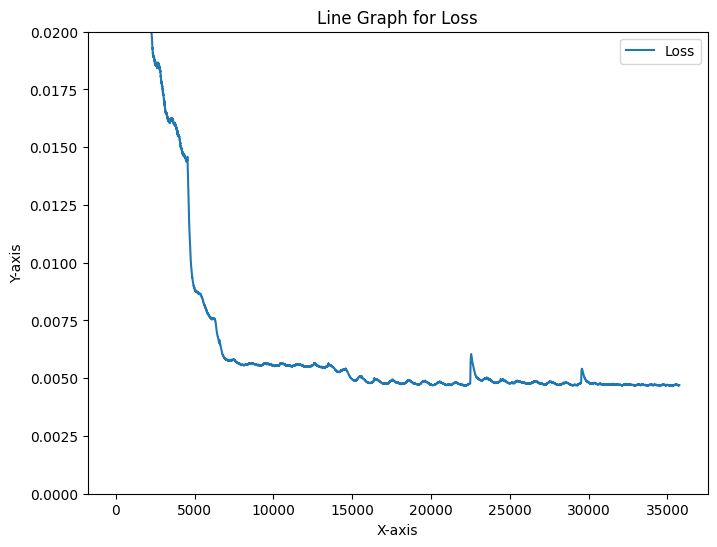

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sns.lineplot(x=range(len(loss_storage)), y=loss_storage, label="Loss")

plt.title('Line Graph for Loss')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.gca().set_ylim(0, 0.02)

plt.legend()
plt.show()

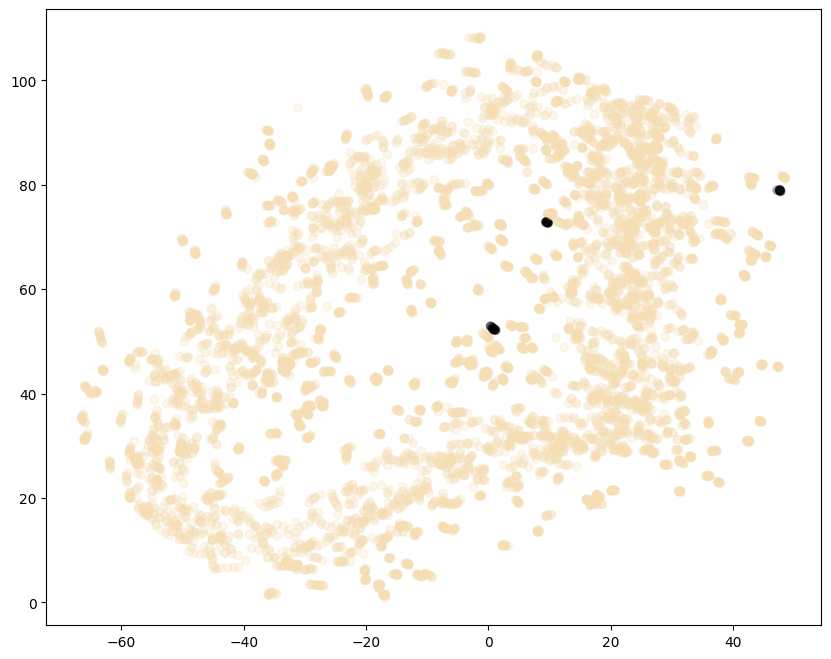

In [142]:
# View three random particle's hits in the generated latent space (from test set)

y, _ = gravnet(raw_data[850].x)
POS = y.detach()
ID = raw_data[850].particle_id

id_np = ID.to('cpu').numpy()
pos_np = POS.to('cpu').numpy()

unique_ids = np.unique(id_np)
highlight_id = np.random.choice(unique_ids)
highlight_id_2 = np.random.choice(unique_ids)
highlight_id_3 = np.random.choice(unique_ids)

colors = ['black' if (id == highlight_id or id == highlight_id_2 or id == highlight_id_3) else 'wheat' for id in id_np]

plt.figure(figsize=(10, 8))
plt.scatter(pos_np[:, 0], pos_np[:, 1], color=colors, alpha=0.25)
plt.show()